# Prediction Intervals

> In this example we show how produce prediction intervals.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/UncertaintyIntervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing NeuralForecast Library

In [ ]:
%%capture
!pip install neuralforecast matplotlib

In [ ]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.losses.pytorch import MQLoss

#### Useful functions

The `plot_grid` function defined below will be useful to plot different time series, and different models' forecasts.

In [ ]:
def plot_grid(df_train, df_test=None, plot_random=True, model=None, level=None):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            for col in ['y', f'{model}-median', 'y_test']:
                if col in test_uid:
                    axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)
            if level is not None:
                for l, alpha in zip(sorted(level), [0.5, .4, .35, .2]):
                    axes[idx, idy].fill_between(
                        test_uid['ds'], 
                        test_uid[f'{model}-lo-{l}'], 
                        test_uid[f'{model}-hi-{l}'],
                        alpha=alpha,
                        color='orange',
                        label=f'{model}_level_{l}',
                    )
        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

## Download data

For testing purposes, we will use the Hourly dataset from the M4 competition.

In [ ]:
%%capture
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv

In [ ]:
train = pd.read_csv('M4-Hourly.csv')
test = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long. You can modify the number of series if you want.

In [ ]:
n_series = 8
uids = train['unique_id'].unique()[:n_series]
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

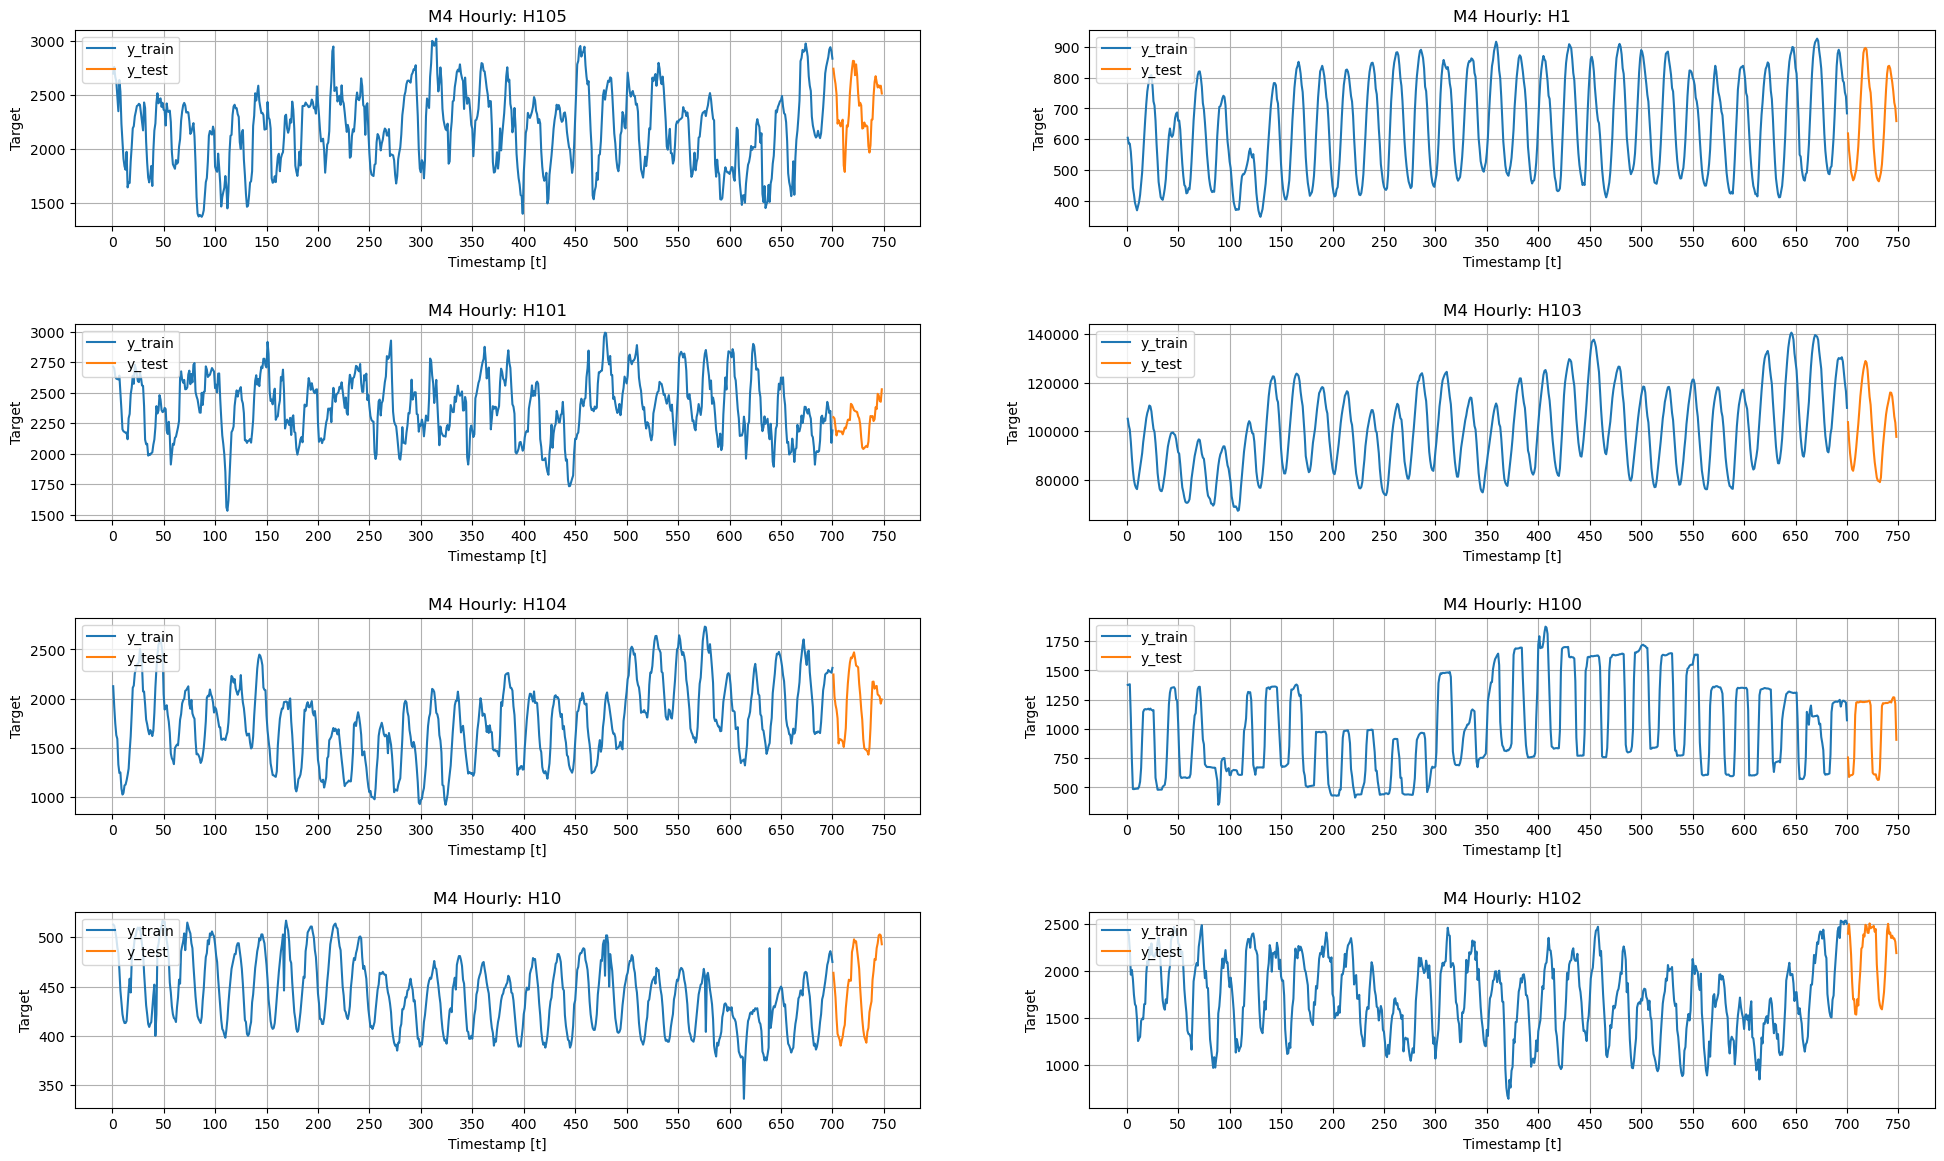

In [ ]:
plot_grid(train, test)

## Train the model

`NeuralForecast` receives a list of models to fit each time series. We can define the level of the forecast intervals we want to produce using the multiquantile loss (`MQLoss`). `NeuralForecast` will produce these levels.

In [ ]:
horizon = 48
levels = [80, 90, 95, 99]
models = [
    NBEATS(input_size=3 * horizon, h=horizon, loss=MQLoss(level=levels), max_epochs=100),
    NHITS(input_size=3 * horizon, h=horizon, loss=MQLoss(level=levels), max_epochs=100),
]

In [ ]:
fcst = NeuralForecast(models=models, freq='H')

In [ ]:
%%capture
fcst.fit(df=train)

In [ ]:
forecasts = fcst.predict()

Predicting DataLoader 0: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 231.19it/s]


In [ ]:
forecasts = forecasts.reset_index()

In [ ]:
forecasts.head()

,unique_id,ds,NBEATS-median,NBEATS-lo-99,NBEATS-lo-95,NBEATS-lo-90,NBEATS-lo-80,NBEATS-hi-80,NBEATS-hi-90,NBEATS-hi-95,NBEATS-hi-99,NHITS-median,NHITS-lo-99,NHITS-lo-95,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,NHITS-hi-95,NHITS-hi-99
0,H1,701,611.138916,512.236511,554.342285,576.594543,584.633972,687.097839,809.628052,656.510986,788.155334,582.381897,354.180206,210.018372,628.719971,591.337769,740.392212,644.796387,710.988586,861.517395
1,H1,702,567.417847,467.404999,410.762634,567.835938,561.770996,740.261963,760.706055,682.496521,1013.163818,559.171631,267.767883,343.095825,407.506256,549.364746,586.956177,563.796509,619.518982,650.819702
2,H1,703,493.827393,249.678650,199.609894,446.651855,482.103607,485.553955,518.839966,624.520996,716.125610,428.579834,240.171997,324.079071,513.841736,482.023560,763.137939,667.640015,705.168091,796.381165
3,H1,704,540.869263,317.709381,418.055145,473.067566,440.767944,524.236145,612.989075,661.831299,566.126404,444.923706,303.869110,428.780396,408.649414,430.571899,478.743347,559.508545,613.073120,652.923706
4,H1,705,487.881775,209.952255,329.020447,420.943237,391.042511,506.642883,573.119080,542.796143,913.441772,416.744354,149.833496,382.192902,426.157257,374.537598,485.822723,542.930359,737.189575,686.591370


In [ ]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

## Plot prediction intervals

Then we can plot the prediction intervals for each model as follows.

### NBEATS

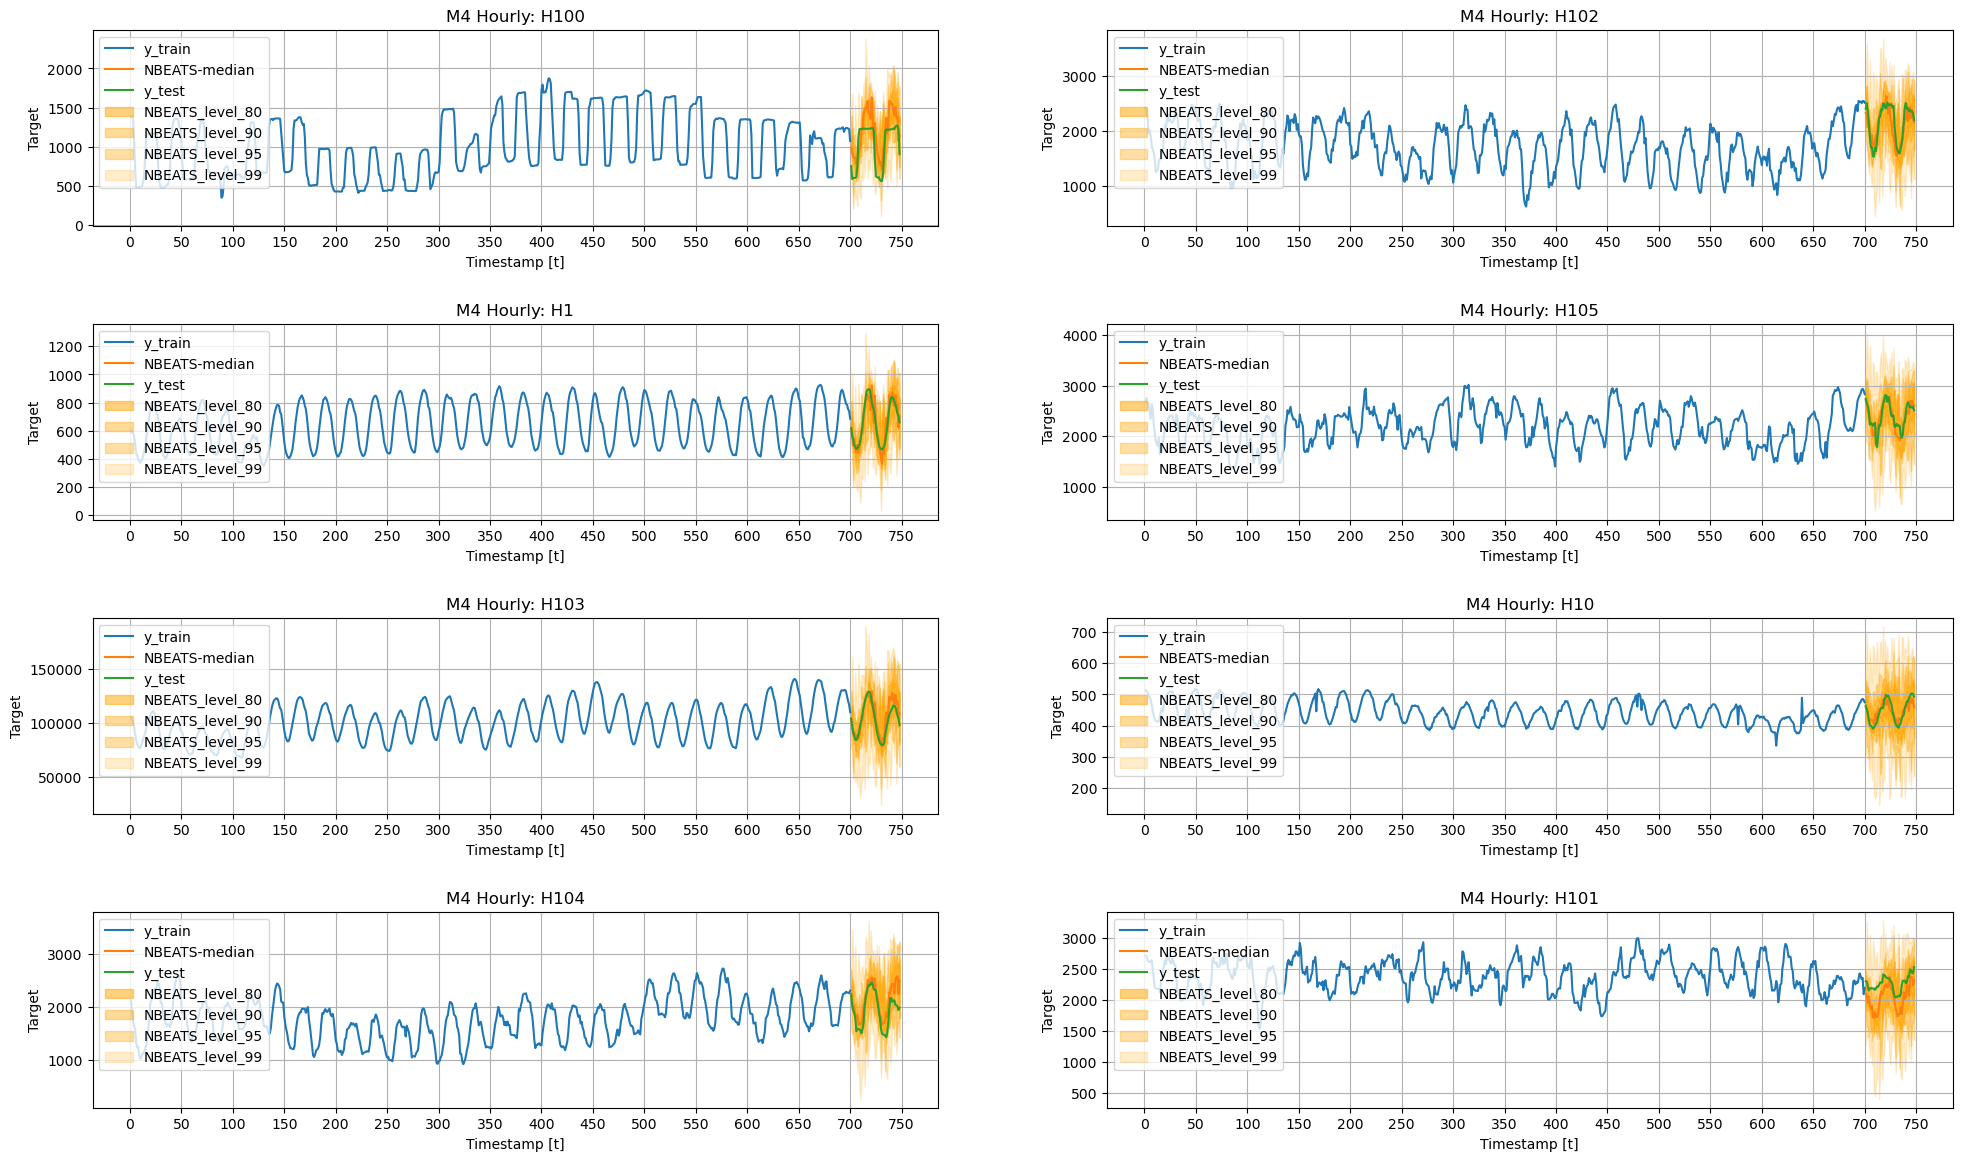

In [ ]:
plot_grid(train, test, level=levels, model='NBEATS')

### NHITS

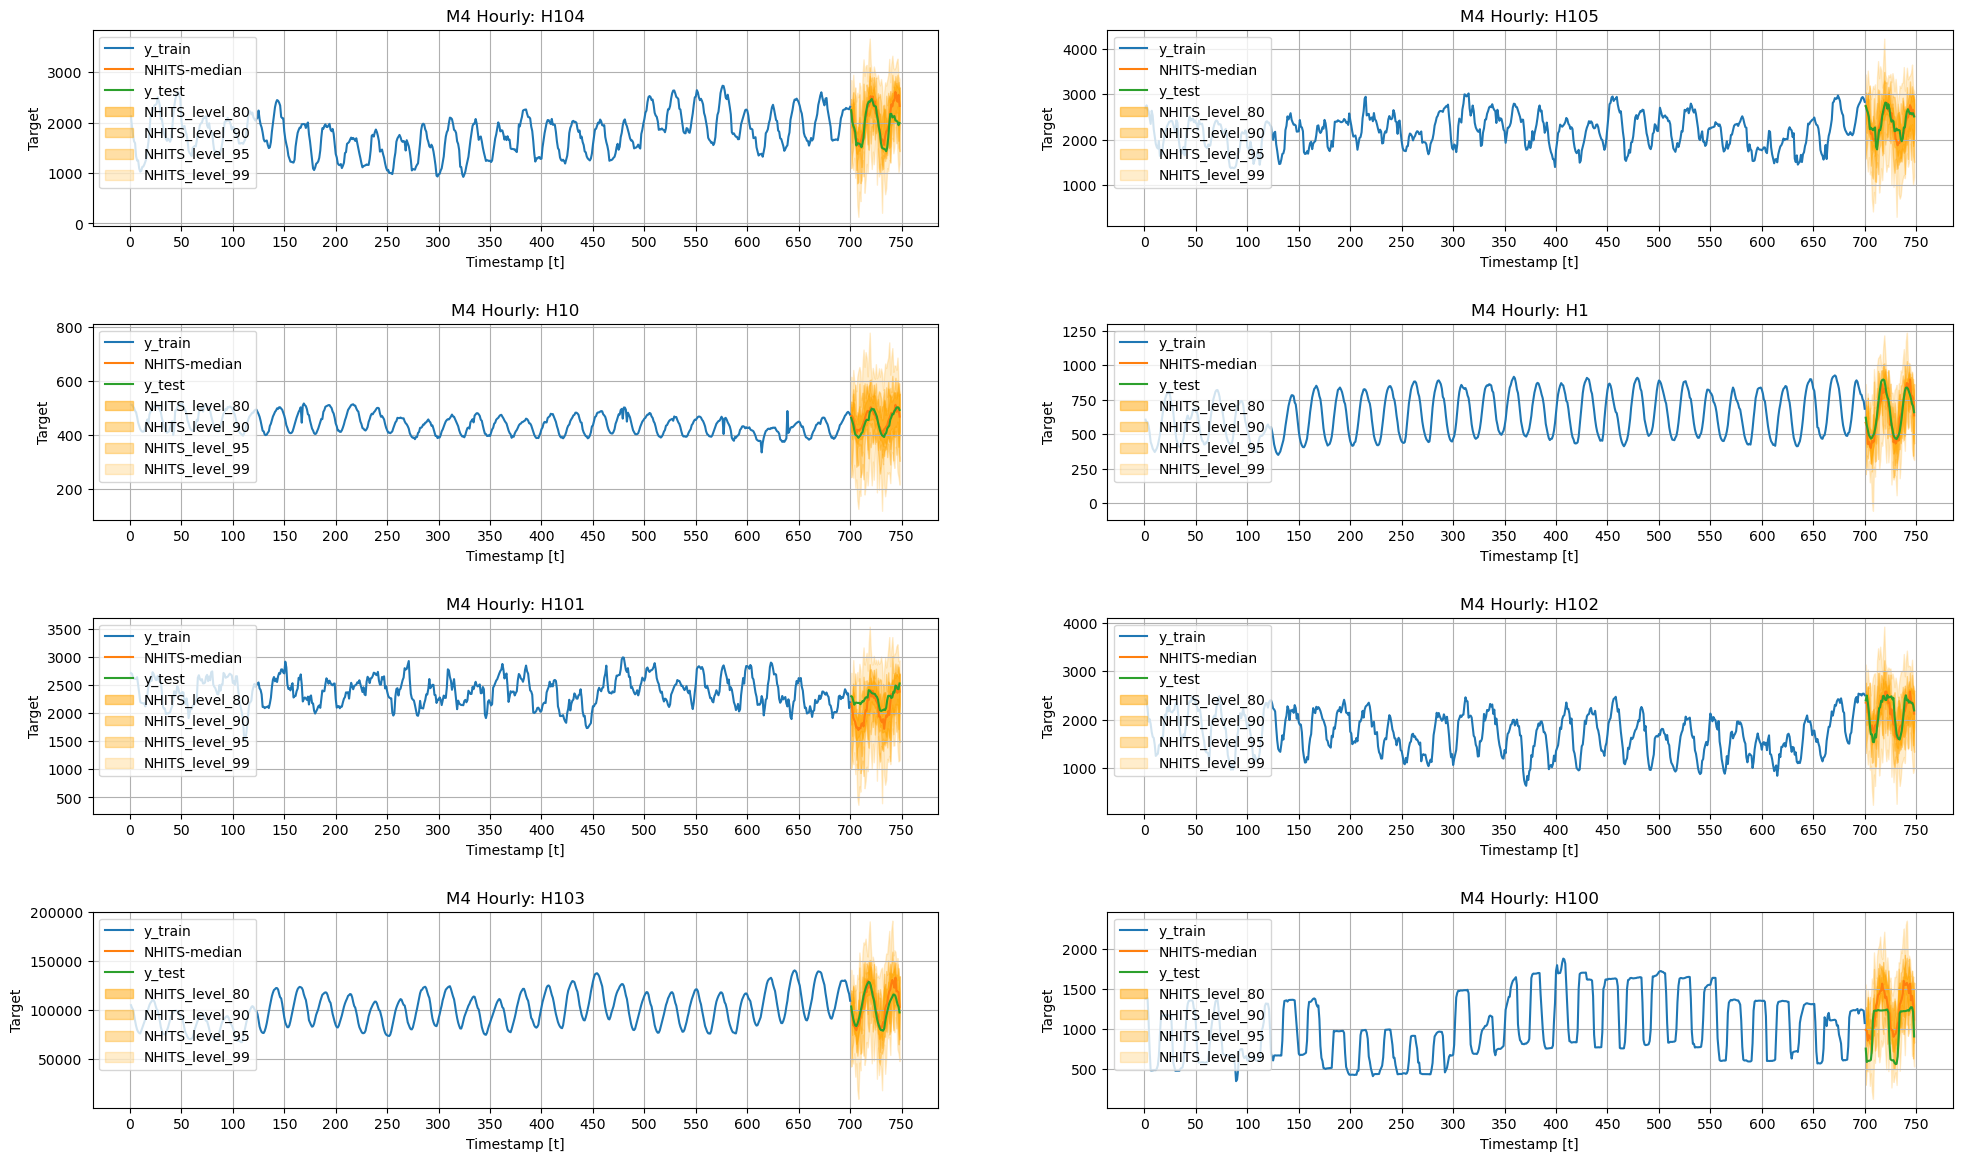

In [ ]:
plot_grid(train, test, level=levels, model='NHITS')

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/UncertaintyIntervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>